In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [123]:
df_L1 = pd.read_csv("./Data/clientCircuitBreaker/L1/results.jtl")
docker_df_L1 = pd.read_csv("./Data/clientCircuitBreaker/L1/docker_stats_live.csv")

df_L2 = pd.read_csv("./Data/clientCircuitBreaker/L2/results.jtl")
docker_df_L2 = pd.read_csv("./Data/clientCircuitBreaker/L2/docker_stats_live.csv")

df_L3 = pd.read_csv("./Data/clientCircuitBreaker/L3/results.jtl")
docker_df_L3 = pd.read_csv("./Data/clientCircuitBreaker/L3/docker_stats_live.csv")

In [125]:
df_L1.head()
df_L1.columns 

df_L2.head()
df_L2.columns 

df_L3.head()
df_L3.columns


Index(['timeStamp', 'elapsed', 'label', 'responseCode', 'responseMessage',
       'threadName', 'dataType', 'success', 'failureMessage', 'bytes',
       'sentBytes', 'grpThreads', 'allThreads', 'URL', 'Latency', 'IdleTime',
       'Connect'],
      dtype='object')

In [127]:
df_L1_success = df_L1[df_L1["responseCode"] == 200]
df_L2_success = df_L2[df_L2["responseCode"] == 200]
df_L3_success = df_L3[df_L3["responseCode"] == 200]

In [131]:
def extract_metrics(df, label):
    return {
        "Laststufe": label,
        "Mittelwert": df["elapsed"].mean(),
        "95. Perzentil": df["elapsed"].quantile(0.95),
        "Maximum": df["elapsed"].max()
    }

reaction_df = pd.DataFrame([
    extract_metrics(df_L1_success, "L1 – Geringe Last"),
    extract_metrics(df_L2_success, "L2 – Mittlere Last"),
    extract_metrics(df_L3_success, "L3 – Hohe Last")
])


In [76]:
print("L1:", df_L1_success["elapsed"].min(), "–", df_L1_success["elapsed"].max())
print("L2:", df_L2_success["elapsed"].min(), "–", df_L2_success["elapsed"].max())
print("L3:", df_L3_success["elapsed"].min(), "–", df_L3_success["elapsed"].max())


L1: 3 – 64645
L2: 2 – 65343
L3: 4 – 65328


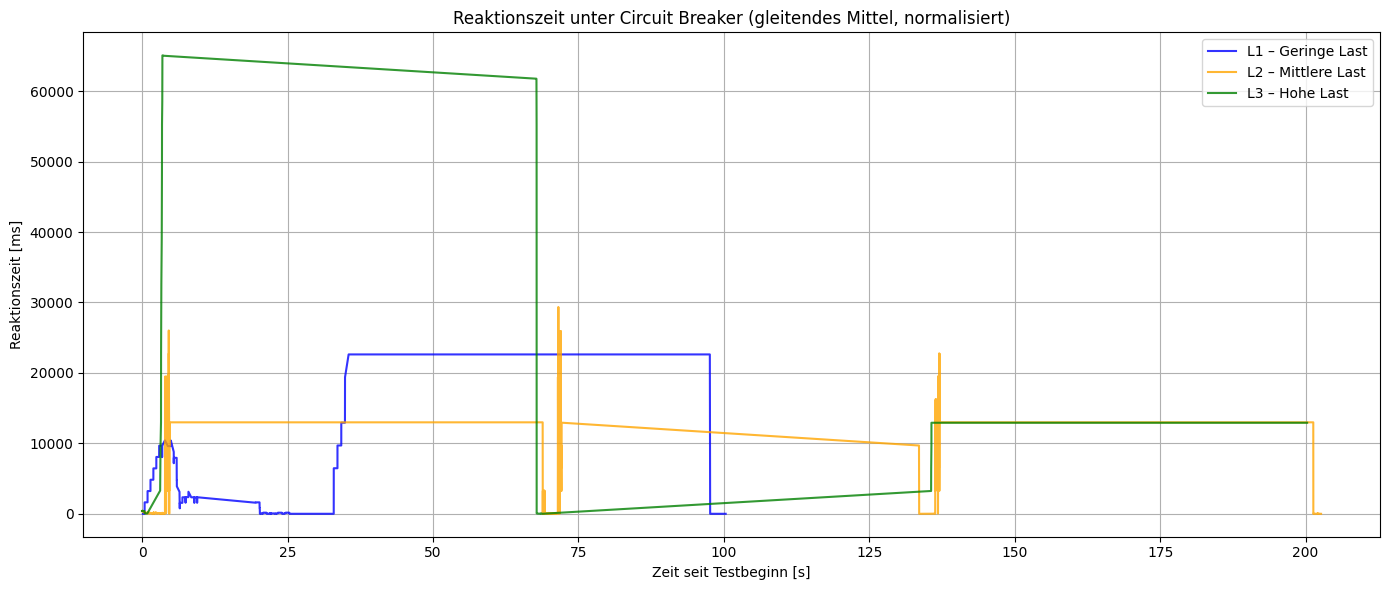

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Hilfsfunktion: Zeit normalisieren ---
def normalize_and_sort(df):
    df = df.copy()  # Vermeidet SettingWithCopyWarning
    df["time"] = pd.to_datetime(df["timeStamp"], unit="ms")
    df["t_norm"] = (df["time"] - df["time"].min()).dt.total_seconds()
    df = df.sort_values("t_norm")  # Ganz wichtig!
    return df

# --- Daten vorbereiten (nur erfolgreiche Anfragen) ---
df_L1_success = df_L1[df_L1["responseCode"] == 200]
df_L2_success = df_L2[df_L2["responseCode"] == 200]
df_L3_success = df_L3[df_L3["responseCode"] == 200]

df_L1_norm = normalize_and_sort(df_L1_success)
df_L2_norm = normalize_and_sort(df_L2_success)
df_L3_norm = normalize_and_sort(df_L3_success)

# --- Gleitendes Mittel über 20 Anfragen ---
df_L1_norm["rolling"] = df_L1_norm["elapsed"].rolling(window=20).mean()
df_L2_norm["rolling"] = df_L2_norm["elapsed"].rolling(window=20).mean()
df_L3_norm["rolling"] = df_L3_norm["elapsed"].rolling(window=20).mean()

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(df_L1_norm["t_norm"], df_L1_norm["rolling"], label="L1 – Geringe Last", alpha=0.8, color="blue")
plt.plot(df_L2_norm["t_norm"], df_L2_norm["rolling"], label="L2 – Mittlere Last", alpha=0.8, color="orange")
plt.plot(df_L3_norm["t_norm"], df_L3_norm["rolling"], label="L3 – Hohe Last", alpha=0.8, color="green")

plt.title("Reaktionszeit unter Circuit Breaker (gleitendes Mittel, normalisiert)")
plt.xlabel("Zeit seit Testbeginn [s]")
plt.ylabel("Reaktionszeit [ms]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


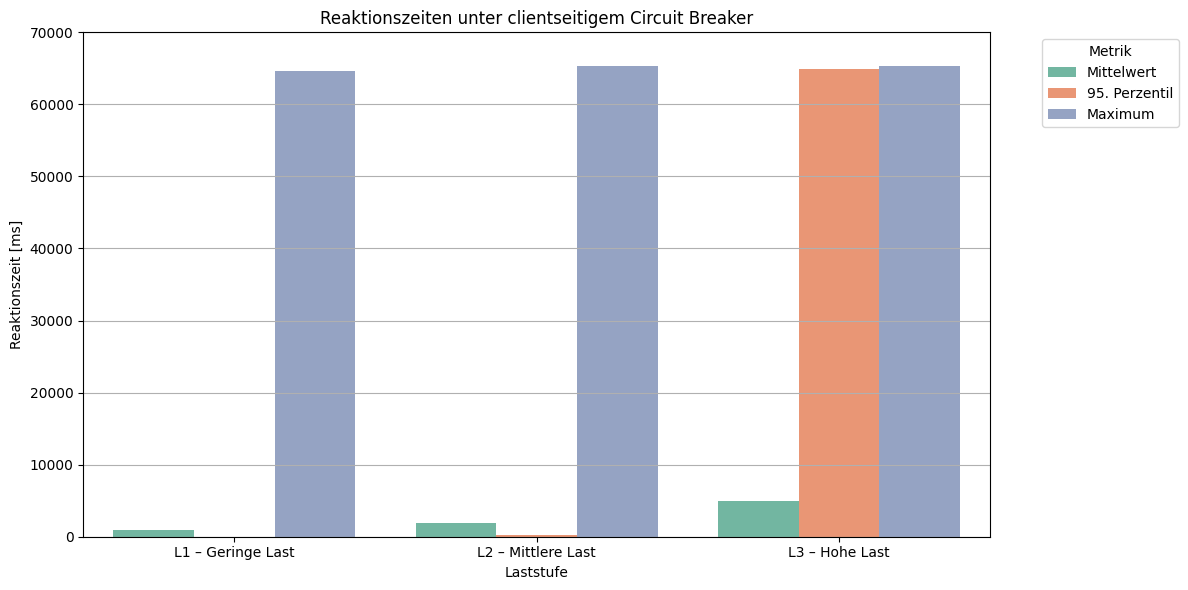

In [132]:
reaction_melted = reaction_df.melt(id_vars="Laststufe", var_name="Metrik", value_name="Reaktionszeit [ms]")

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=reaction_melted, x="Laststufe", y="Reaktionszeit [ms]", hue="Metrik")

plt.title("Reaktionszeiten unter clientseitigem Circuit Breaker")
plt.xlabel("Laststufe")
plt.ylabel("Reaktionszeit [ms]")
plt.ylim(0, 70000)
plt.grid(True, axis="y")
plt.legend(title="Metrik", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

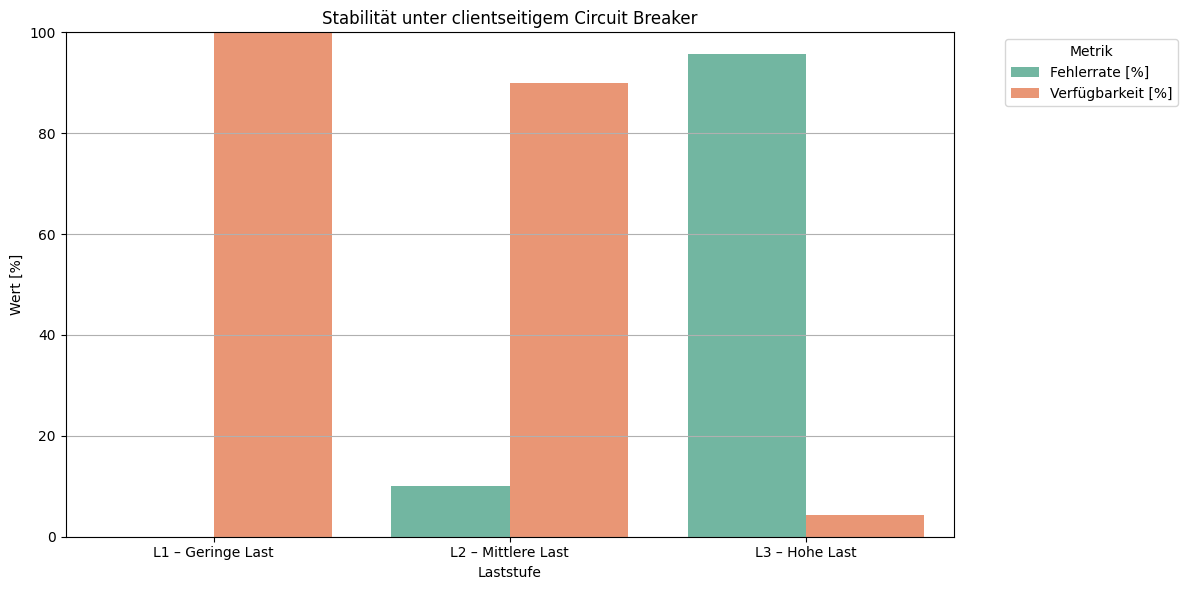

In [160]:
# Vorbereitung: Prozent statt Anteil [0–1]
summary_plot = stability_df[["Laststufe", "Fehlerrate [%]", "Verfügbarkeit [%]"]].copy()

# Umformen fürs Diagramm
summary_melted = summary_plot.melt(
    id_vars="Laststufe",
    var_name="Metrik",
    value_name="Wert [%]"
)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=summary_melted, x="Laststufe", y="Wert [%]", hue="Metrik")

plt.title("Stabilität unter clientseitigem Circuit Breaker")
plt.xlabel("Laststufe")
plt.ylabel("Wert [%]")
plt.ylim(0, 100)
plt.grid(True, axis="y")
plt.legend(title="Metrik", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


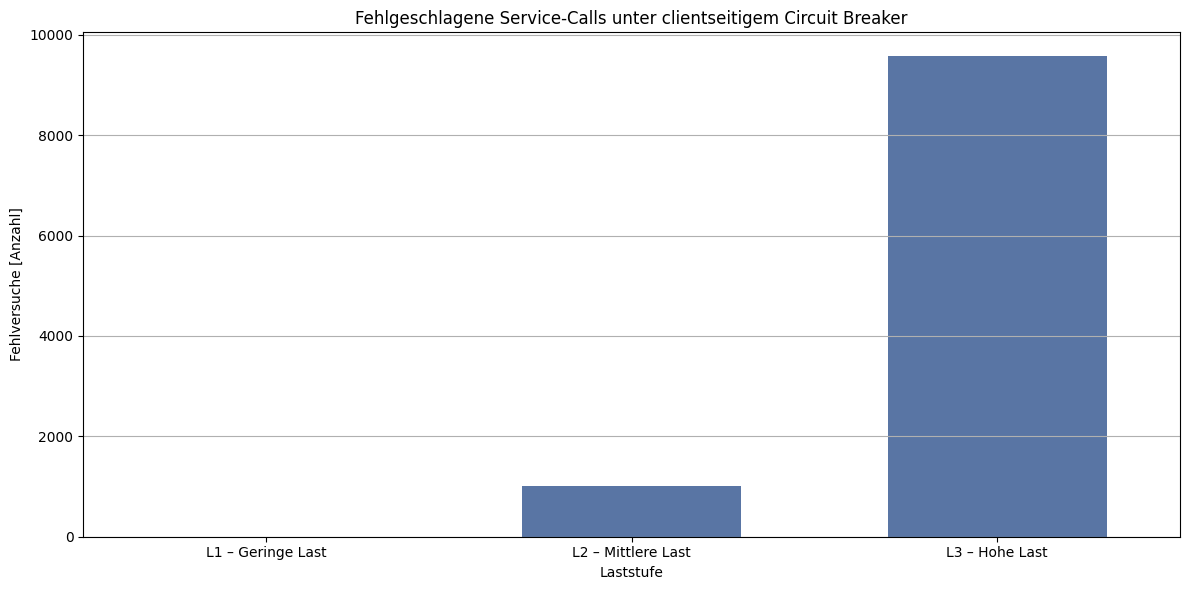

In [182]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=stability_df, x="Laststufe", y="Fehlversuche [Anzahl]", color="#4C72B0", width=0.6)

plt.title("Fehlgeschlagene Service-Calls unter clientseitigem Circuit Breaker")
plt.xlabel("Laststufe")
plt.ylabel("Fehlversuche [Anzahl]")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


In [164]:
def parse_docker_stats(csv_path, label):
    df = pd.read_csv(csv_path, names=["Container", "CPU", "RAM", "NetIO"])
    relevant = ["myservice", "backend-a-1", "backend-b-1"]
    df = df[df["Container"].isin(relevant)].copy()
    
    # Korrektur hier ↓↓↓
    df[["RAM_Used", "RAM_Total"]] = df["RAM"].str.split(" / ", expand=True)
    df[["Net_In", "Net_Out"]] = df["NetIO"].str.split(" / ", expand=True)
    
    df["CPU_%"] = df["CPU"].str.replace("%", "").astype(float)

    def convert_to_mib(x):
        if "MiB" in x: return float(x.replace("MiB", ""))
        if "GiB" in x: return float(x.replace("GiB", "")) * 1024
        if "KiB" in x: return float(x.replace("KiB", "")) / 1024
        return 0
    df["RAM_Used_MiB"] = df["RAM_Used"].apply(convert_to_mib)

    def convert_to_mb(x):
        if "MB" in x: return float(x.replace("MB", ""))
        if "kB" in x: return float(x.replace("kB", "")) / 1024
        if "B" in x: return float(x.replace("B", "")) / (1024 * 1024)
        return 0
    df["Net_In_MB"] = df["Net_In"].apply(convert_to_mb)
    df["Net_Out_MB"] = df["Net_Out"].apply(convert_to_mb)

    df["Laststufe"] = label
    return df



In [165]:
df_L1 = parse_docker_stats("./Data/clientCircuitBreaker/L1/docker_stats_live.csv", "L1 – Geringe Last")
df_L2 = parse_docker_stats("./Data/clientCircuitBreaker/L2/docker_stats_live.csv", "L2 – Mittlere Last")
df_L3 = parse_docker_stats("./Data/clientCircuitBreaker/L3/docker_stats_live.csv", "L3 – Hohe Last")

df_all = pd.concat([df_L1, df_L2, df_L3])


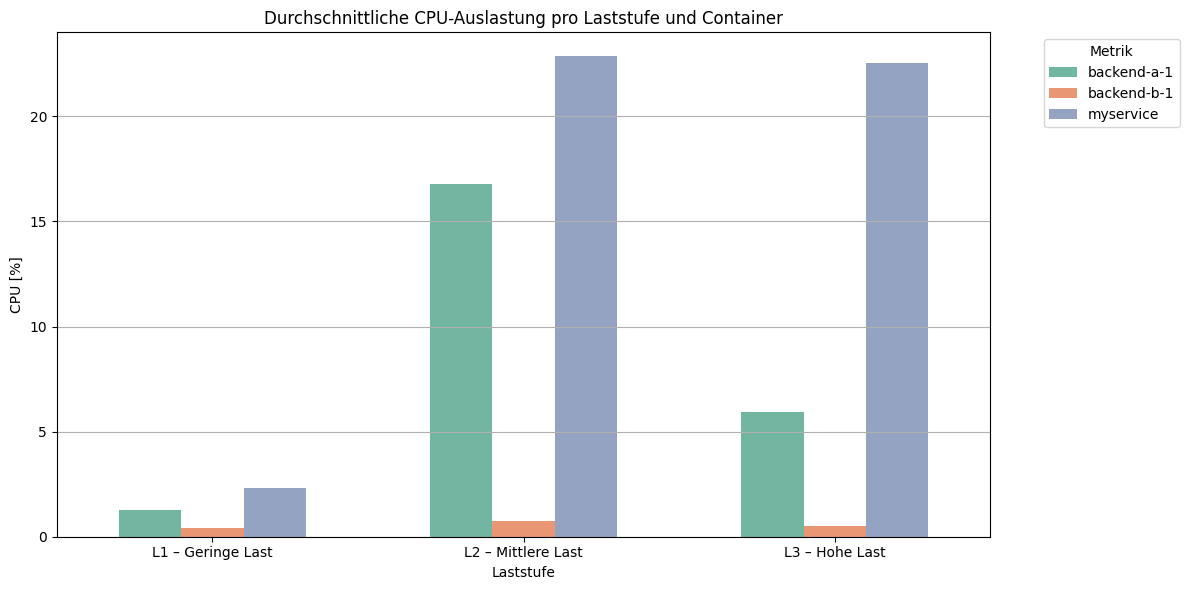

In [178]:
cpu = df_all.groupby(["Laststufe", "Container"])["CPU_%"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=cpu, x="Laststufe", y="CPU_%", hue="Container", width=0.6)
plt.title("Durchschnittliche CPU-Auslastung pro Laststufe und Container")
plt.ylabel("CPU [%]")
plt.grid(True, axis="y")
plt.legend(title="Metrik", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


/tmp/ipykernel_8855/3634157173.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=ram_melted, x="Laststufe", y="RAM [MiB]", hue="Metrik", ci=None, width=0.6)


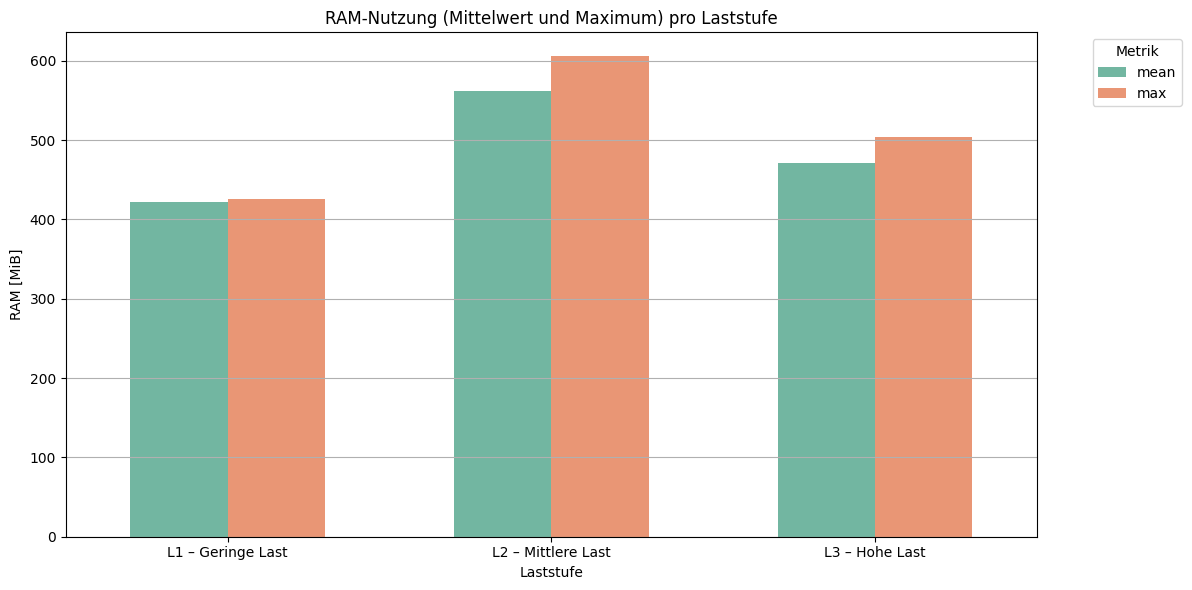

In [177]:
ram = df_all.groupby(["Laststufe", "Container"])["RAM_Used_MiB"].agg(["mean", "max"]).reset_index()
ram_melted = ram.melt(id_vars=["Laststufe", "Container"], var_name="Metrik", value_name="RAM [MiB]")

plt.figure(figsize=(12, 6))
sns.barplot(data=ram_melted, x="Laststufe", y="RAM [MiB]", hue="Metrik", ci=None, width=0.6)
plt.title("RAM-Nutzung (Mittelwert und Maximum) pro Laststufe")
plt.ylabel("RAM [MiB]")
plt.grid(True, axis="y")
plt.legend(title="Metrik", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


/tmp/ipykernel_8855/3958859592.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=net_melted, x="Laststufe", y="Netzwerk [MB]", hue="Richtung", ci=None, width=0.6)


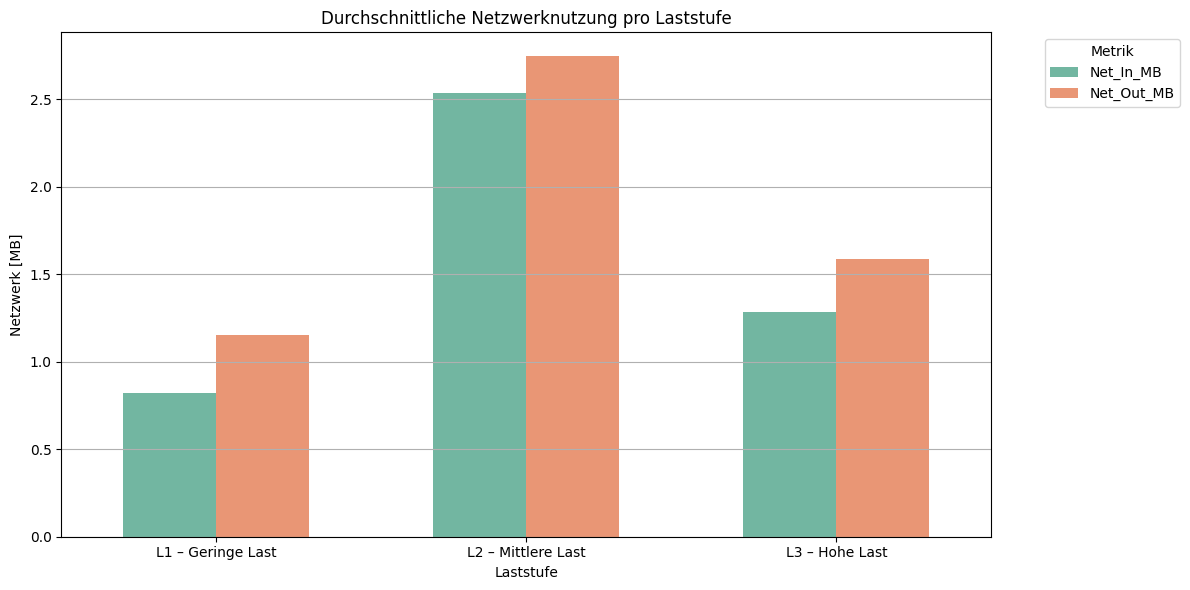

In [176]:
net = df_all.groupby(["Laststufe", "Container"])[["Net_In_MB", "Net_Out_MB"]].mean().reset_index()
net_melted = net.melt(id_vars=["Laststufe", "Container"], var_name="Richtung", value_name="Netzwerk [MB]")

plt.figure(figsize=(12, 6))
sns.barplot(data=net_melted, x="Laststufe", y="Netzwerk [MB]", hue="Richtung", ci=None, width=0.6)
plt.title("Durchschnittliche Netzwerknutzung pro Laststufe")
plt.ylabel("Netzwerk [MB]")
plt.grid(True, axis="y")
plt.legend(title="Metrik", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
